# Instance creator utility

In [1]:
import xml.etree.ElementTree as ET
import numpy as np
import matplotlib.pyplot as plt
import sys, os
from scipy.io import loadmat
import pandas as pd

from matplotlib import rcParams
rcParams['text.usetex'] = True

sys.path.append('..')
import res.models.Fleet as Fleet
import res.models.Network as Network

### Paths

In [2]:
main_folder = '../data/test/'
mat_path = '../data/online/instance21/init_files/21_nodes.mat'

## Standard travel time and energy consumption profile

In [3]:
def edge_data(data, i, j, t):
    soc_data = data['starting_time'][0][t]['origin'][0][i]['destination'][0][j]['soc'][0]*24
    tt_data  = data['starting_time'][0][t]['origin'][0][i]['destination'][0][j]['time'][0]/60
    soc_mean, tt_mean = np.mean(soc_data), np.mean(tt_data)
    soc_std, tt_std = np.std(soc_data), np.std(tt_data)    
    return (soc_mean, tt_mean), (soc_std, tt_std)

data = loadmat(mat_path)

network_size = len(data['starting_time'][0][0]['origin'][0])
data_points = len(data['starting_time'][0])

soc_matrix, tt_matrix = np.zeros((1, data_points)), np.zeros((1, data_points))
samples = 0

for i in range(network_size):
    for j in range(network_size):
        if i != j:
            (soc_mean, tt_mean), (soc_std, tt_std) = edge_data(data, i, j, 0)
            dij = 35*tt_mean/60.  # km
            if dij == .0:
                continue
            soc_array, tt_array = np.zeros((1, data_points)), np.zeros((1, data_points))
            for t in range(data_points):
                (soc_mean, tt_mean), (soc_std, tt_std) = edge_data(data, i, j, t)
                v = 60*dij/tt_mean  # km/h
                t1km = 60/v  # min
                E1km = soc_mean/dij
                tt_array[0, t] = t1km
                soc_array[0, t] = E1km
            soc_matrix = np.append(soc_matrix, soc_array, axis = 0)
            tt_matrix = np.append(tt_matrix, tt_array, axis = 0)


In [4]:
tt_mean = np.mean(tt_matrix, axis=0)
ec_mean = np.mean(soc_matrix, axis=0)

tt_std = np.std(tt_matrix, axis=0)
ec_std = np.std(soc_matrix, axis=0)

x = range(len(tt_mean))

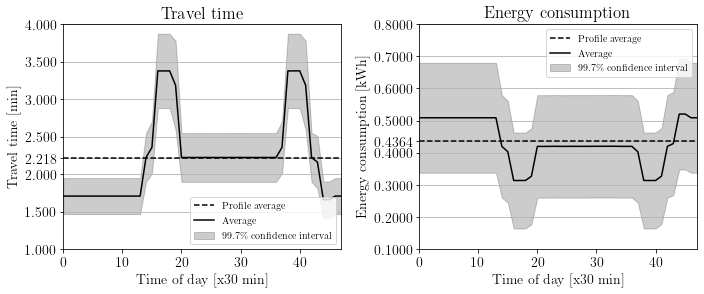

In [5]:
fig_width, fig_height = 10, 12.941
full_figratio = (fig_width, fig_height)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(fig_width, fig_height/3))


y = tt_mean
y0 = tt_mean - 3*tt_std
y1 = tt_mean + 3*tt_std
tt_mean_global = np.mean(tt_mean)

color = 'black'
#ax1.errorbar(x, tt_mean, tt_std, color=color)
ax1.fill_between(x, y0, y1, alpha=.2, color=color, label='99.7\% confidence interval')
ax1.axhline(tt_mean_global, color=color, linestyle='--', label='Profile average')
ax1.plot(x, y, marker='', markersize=4, color='k', label='Average')

ax1.set_xlabel('Time of day [x30 min]')
ax1.set_ylabel('Travel time [min]', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_yticks(list(ax1.get_yticks()) + [tt_mean_global])
ax1.set_title('Travel time')
ax1.set_xlim(0, 47)
ax1.grid(axis='y')
ax1.legend(loc='lower right', fontsize=10)


y = ec_mean
y0 = ec_mean - ec_std
y1 = ec_mean + ec_std
ec_mean_global = np.mean(ec_mean)

color = 'black'
#ax2.errorbar(x, ec_mean, 3*ec_std, color=color, elinewidth=.8)
ax2.fill_between(x, y0, y1, alpha=.2, color = color, label='99.7\% confidence interval')
ax2.axhline(ec_mean_global, color=color, linestyle='--', label='Profile average')
ax2.plot(x, ec_mean, color=color, label='Average')

ax2.set_xlabel('Time of day [x30 min]')
ax2.set_ylabel('Energy consumption [kWh]', color=color)  # we already handled the x-label with ax1
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_yticks(list(ax2.get_yticks()) + [ec_mean_global])
ax2.grid(axis='y')
ax2.set_title('Energy consumption')
ax2.set_xlim(0, 47)
ax2.legend(loc='upper right', fontsize=10)

#fig.suptitle(f'1-Kilometer Profile')
fig.tight_layout()
#fig.subplots_adjust(top=0.85)

In [6]:
#fig.savefig('../data/online/instance21/1kmProfile.pdf')

## Create network

### Network params

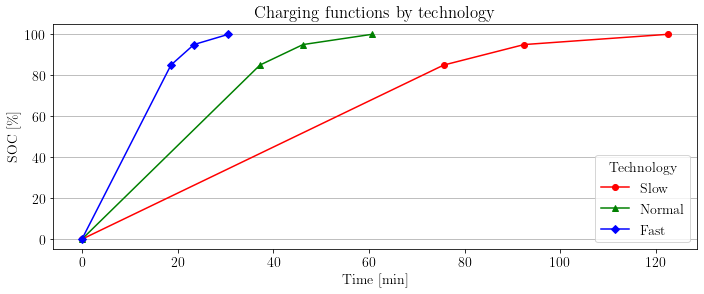

In [6]:
n_customers = 15
n_charg_sta = 2
minx, maxx = -15, 15 # km
miny, maxy = -15, 15 # km
minreq, maxreq = 0.01, 0.08
mintime, maxtime = 8, 15
mintw_low, maxtw_low = 60*9, 60*15
mintw_width, maxtw_width = 60*2.5, 60*3.5
cs_capacity = 2

# CS technologies
tech1 = {0.0: 0.0, 75.6: 85.0, 92.4: 95.0, 122.4: 100.0} # slow
tech2 = {0.0: 0.0, 37.2: 85.0, 46.2: 95.0, 60.6: 100.0}  # normal
tech3 = {0.0: 0.0, 18.6: 85.0, 23.4: 95.0, 30.6: 100.0}  # fast
tech_list = [tech1, tech2, tech3]
tech_price = [70., 70.*1.5, 70.*2.5]

# Plot charging functions
fig, ax = plt.subplots(figsize=(fig_width, fig_height/3))
style_list = [('Slow', '-ro'), ('Normal', '-g^'), ('Fast', '-bD')]
for tech, (label, style) in zip(tech_list, style_list):
    t = list(tech.keys())
    soc = list(tech.values())
    ax.plot(t, soc, style, label=label)
    
ax.set_xlabel('Time [min]')
ax.set_ylabel('SOC [\%]')
ax.set_title('Charging functions by technology')
ax.grid(axis='y')    
ax.legend(title='Technology')
fig.tight_layout()
#fig.savefig('../pictures/chargingFunctions.pdf')

### Instance network

In [7]:
# Dictionaries with nodes and edges
nodes = {}
edges = {}

for i in range(1 + n_customers + n_charg_sta):
    cx = float('{:.2f}'.format(np.random.uniform(minx, maxx)))
    cy = float('{:.2f}'.format(np.random.uniform(miny, maxy)))
    
    # Depot
    if i == 0:
        node = Network.DepotNode(0, 0, 0, 0, 0)

    # Customers
    elif 1 <= i < 1 + n_customers:
        spent_time = float('{:.2f}'.format(np.random.uniform(mintime, maxtime)))
        demand = float('{:.2f}'.format(np.random.uniform(minreq, maxreq)))
        tw_low = float('{:.2f}'.format(np.random.uniform(mintw_low, maxtw_low)))
        tw_upp = float('{:.2f}'.format(tw_low + np.random.uniform(mintw_width, maxtw_width)))
        node = Network.CustomerNode(i, spent_time, demand, cx, cy, tw_low, tw_upp)

    # Charging Stations
    elif 1 <= i < n_customers + n_charg_sta:
            j = np.random.randint(3)
            time_points, soc_points = tuple(tech_list[j].keys()), tuple(tech_list[j].values())
            node = Network.ChargeStationNode(i, 0, 0, cx, cy, cs_capacity, time_points, soc_points, j + 1, tech_price[j])
    # Charging station at depot
    else:
        j = np.random.randint(3)
        time_points, soc_points = tuple(tech_list[j].keys()), tuple(tech_list[j].values())
        node = Network.ChargeStationNode(i, 0, 0, 0, 0, cs_capacity, time_points, soc_points, j + 1, tech_price[j])
        
    nodes[i] = node

In [8]:
# Edges
for i in range(1 + n_customers + n_charg_sta):
    edges[i] = {}
    for j in range(1 + n_customers + n_charg_sta):
        a, b = nodes[i], nodes[j]
        dist = np.sqrt((a.pos_x-b.pos_x)**2 + (a.pos_y-b.pos_y)**2)
        tAB = dist*tt_mean
        tAB_std = dist*tt_std if dist > 0 else np.zeros_like(tt_mean)
        eAB = 1.82*dist*ec_mean
        eAB_std = ec_std if dist > 0 else np.zeros_like(ec_mean)
        edge = Network.GaussianEdge(i, j, 30., tAB, eAB, dist)
        edges[i][j] = edge
        #print(f'mean [{i}][{j}]:\n', eAB, '\nstd:\n', eAB_std)
        if min(tAB) < 3*max(tAB_std):
            print(f'DANGER in TIME [{i}][{j}]', min(tAB), 3*max(tAB_std))
        if min(eAB) < 3*max(eAB_std):
            print(f'DANGER in EC [{i}][{j}]', min(eAB), 3*max(eAB_std))

(<Figure size 432x288 with 1 Axes>,
 <networkx.classes.digraph.DiGraph at 0x2b0841c0948>)

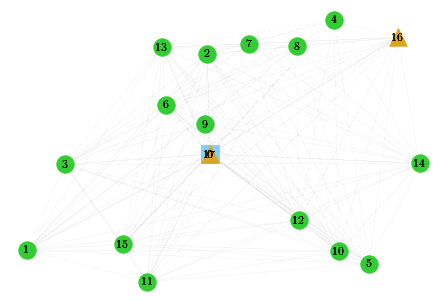

In [9]:
# Instance network
network = Network.Network(nodes, edges)
network.draw(save_to=None, width=0.003, edge_color='grey', markeredgecolor='black', markeredgewidth=2.0)

In [12]:
# Save network
network.write_xml(f'{main_folder}/network.xml')

TypeError: zip argument #1 must support iteration

## Create fleet

### Fleet params

In [27]:
ev_id = 0
alpha_down, alpha_upp = 0, 100
battery_capacity = 24  # kWh
battery_capacity_nominal = battery_capacity
max_payload = 0.553 # tonnes
weight = 1.52  # tonnes
max_tour_duration = 6*60.

### Instance fleet

In [30]:
ev = Fleet.ElectricVehicle(ev_id, weight, battery_capacity, battery_capacity_nominal, alpha_upp, alpha_down, max_tour_duration, max_payload)
fleet = Fleet.Fleet({0: ev})

### Save fleet

In [33]:
fleet.write_xml(f'{main_folder}/fleet.xml', False, print_pretty=True)